In [15]:
from __future__ import print_function, division
from collections import defaultdict, namedtuple
import os
import pickle
import random
import math
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, SGDClassifier
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import ParameterGrid, ParameterSampler, StratifiedShuffleSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor
from collections import Counter

In [81]:
def genIntgers(n, forward= True):
    for i in xrange(2):
        if forward == True:
            yield n - i
        else:
            yield n + i

def NamedTuple(name='NamedTuple', **kwargs):
    dt = dict(**kwargs)
    return namedtuple(name, sorted(dt))(**dt)

def ScaleX(X, scale =None):
#     print(np.min(X),np.max(X))
    if scale is None:
        stdSlr = StandardScaler()
        stdSlr.fit(X)
        X_std = stdSlr.transform(X)
        return X_std, stdSlr
    else:
        X_std = scale.transform(X)
        return X_std, scale

def l1finder(trainX, trainY, choice, scale = None):
    if scale is not None:
        trainX = ScaleX(trainX, scale)[0]
    if choice=='SGD':
        pg = {'alpha':sorted([10**i for i in xrange(-5, 5, 1)], reverse=True)}
        clf = SGDClassifier(loss='log', penalty='elasticnet', alpha=0.1, l1_ratio=1,
                            fit_intercept=True, max_iter=10, tol=.0001, learning_rate='optimal', warm_start=True)
    
    for params in ParameterGrid(pg):
        clf.set_params(**params)
        clf.fit(trainX, trainY)
        if np.count_nonzero(clf.coef_[0]) >= 5:
            break
    print(params, 'features selected:', np.count_nonzero(clf.coef_[0]))
    return params

def tryGrid(X, Y, valX, valY, maxalpha, scale = None):
    Register = defaultdict(dict) 
    if scale is not None:
        X = ScaleX(X, scale)[0]
    n = int(np.log10(maxalpha))
    pg = {'alpha':sorted([10**i for i in genIntgers(n, forward= True)], reverse= True), 
          'l1_ratio': [x/100.0 for x in range(10,100,10)]}
    param_grid = ParameterGrid(pg)
    best_vroc = 0
    best_model = 0
    imp_feats_ind = []
    for params in param_grid:
        print(params , X.shape)
        SGDElastic = SGDClassifier(loss='log', penalty='elasticnet', alpha=params['alpha'], l1_ratio=params['l1_ratio'],
                   fit_intercept=True, max_iter=200000000, tol=.0001, learning_rate='optimal', warm_start=True)
        SGDElastic.fit(X,Y)
        valX1, valX2, valY1, valY2 = train_test_split(valX, valY, test_size=.5, random_state=42, stratify=valY)
        vroc1 = roc_auc_score(valY1, SGDElastic.predict_proba(valX1)[:, 1])
        vroc2 = roc_auc_score(valY2, SGDElastic.predict_proba(valX2)[:, 1])
        troc = roc_auc_score(Y, SGDElastic.predict_proba(X)[:, 1])
        avg_vroc = np.average([vroc1, vroc2])
        feat_ind = np.nonzero(SGDElastic.coef_[0])[0]
        Register[NamedTuple(name='pairs', **params)]['numVars'] = np.count_nonzero(SGDElastic.coef_[0])
        Register[NamedTuple(name='pairs', **params)]['varsInd'] = feat_ind
        Register[NamedTuple(name='pairs', **params)]['troc'] = troc 
        Register[NamedTuple(name='pairs', **params)]['vroc']= avg_vroc
        Register[NamedTuple(name='pairs', **params)]['diff'] = (troc-np.average([vroc1, vroc2]))
        Register[NamedTuple(name='pairs', **params)]['mod'] = SGDElastic
        if (avg_vroc>best_vroc):
            best_vroc = avg_vroc
            best_model = SGDElastic
            imp_feats_ind = feat_ind
    return Register, best_vroc, best_model, imp_feats_ind

def chi_square_selector_k_best(trainX, trainY, valX, valY,scale):
    n=20
    min_max_scale = MinMaxScaler()
    trainX = min_max_scale.fit_transform(trainX)
    test = SelectKBest(score_func=chi2, k="all")
    fit = test.fit(trainX, trainY)
    #features = fit.transform(trainX)
    
    scores = fit.scores_
    imp_feats_ind = scores.argsort()[-20:]
    return imp_feats_ind

def run_gridSearch(X_train, y_train, mod, parameters, cv, refit):
    scoring_dict = {'AUC':'roc_auc', 'Accuracy':'accuracy'}
    clf = GridSearchCV(mod, parameters, cv=cv, n_jobs=1, verbose=3, scoring=scoring_dict, iid=False, refit=refit)
    clf.fit(X_train, y_train)
    best_params = clf.best_params_
    best_score = clf.best_score_
    best_estimator = clf.best_estimator_

def feature_selection(trainX, trainY, valX, valY, scale, cv, refit, choice):
    if choice=='SGD':
        maxalpha = l1finder(trainX, trainY, choice, scale = scale)['alpha']
        Register, best_vroc, best_model, imp_feats_ind = tryGrid(trainX, trainY, valX, valY, maxalpha, scale = scale)
        print ("best roc is ", best_vroc)
    elif choice=='chi': 
        print('Selecting K best Features from Chisquare, K=20')
        imp_feats_ind = chi_square_selector_k_best(trainX, trainY, valX, valY , scale)
    return imp_feats_ind    

In [17]:
df = pd.read_csv("case_study_data.csv")

In [18]:
df.head()

,checkin_acc,duration,credit_history,purpose,amount,svaing_acc,present_emp_since,inst_rate,personal_status,other_debtors,...,property,age,inst_plans,housing,num_credits,job,dependents,telephone,foreign_worker,status
0,A11,9,A34,A43,1754,A65,A75,6,A93,A101,...,A121,101,A143,A152,3,A173,2,A192,A201,1
1,A12,72,A32,A43,8927,A61,A73,3,A92,A101,...,A121,33,A143,A152,2,A173,2,A191,A201,2
2,A14,18,A34,A46,3144,A61,A74,3,A93,A101,...,A121,74,A143,A152,2,A172,3,A191,A201,1
3,A11,63,A32,A42,11823,A61,A74,3,A93,A103,...,A122,68,A143,A153,2,A173,3,A191,A201,1
4,A11,36,A33,A40,7305,A61,A73,5,A93,A101,...,A124,80,A143,A153,3,A173,3,A191,A201,2


In [19]:
low_cardinality_cols = [cname for cname in df.columns if 
                                df[cname].nunique() < 10 and
                                df[cname].dtype == "object"]

In [20]:
df.columns

Index([u'checkin_acc', u'duration', u'credit_history', u'purpose', u'amount',
       u'svaing_acc', u'present_emp_since', u'inst_rate', u'personal_status',
       u'other_debtors', u'residing_since', u'property', u'age', u'inst_plans',
       u'housing', u'num_credits', u'job', u'dependents', u'telephone',
       u'foreign_worker', u'status'],
      dtype='object')

In [21]:
low_cardinality_cols

['checkin_acc',
 'credit_history',
 'svaing_acc',
 'present_emp_since',
 'personal_status',
 'other_debtors',
 'property',
 'inst_plans',
 'housing',
 'job',
 'telephone',
 'foreign_worker']

# data analysis

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns 

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checkin_acc          1000 non-null object
duration             1000 non-null int64
credit_history       1000 non-null object
purpose              1000 non-null object
amount               1000 non-null int64
svaing_acc           1000 non-null object
present_emp_since    1000 non-null object
inst_rate            1000 non-null int64
personal_status      1000 non-null object
other_debtors        1000 non-null object
residing_since       1000 non-null int64
property             1000 non-null object
age                  1000 non-null int64
inst_plans           1000 non-null object
housing              1000 non-null object
num_credits          1000 non-null int64
job                  1000 non-null object
dependents           1000 non-null int64
telephone            1000 non-null object
foreign_worker       1000 non-null object
status               1000 non-null int64
dtypes: int64(8), ob

In [56]:
df.describe()

,duration,amount,inst_rate,residing_since,age,num_credits,dependents,status
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,31.449000,4907.134000,4.606000,4.407000,53.566000,2.441000,2.155000,1.300000
std,18.055564,4234.100176,1.572016,1.570292,17.065664,0.697858,0.362086,0.458487
min,6.000000,375.000000,2.000000,2.000000,29.000000,2.000000,2.000000,1.000000
25%,18.000000,2048.250000,3.000000,3.000000,41.000000,2.000000,2.000000,1.000000
50%,27.000000,3479.500000,5.000000,5.000000,50.000000,2.000000,2.000000,1.000000
75%,36.000000,5958.500000,6.000000,6.000000,63.000000,3.000000,2.000000,2.000000
max,108.000000,27636.000000,6.000000,6.000000,113.000000,6.000000,3.000000,2.000000


In [57]:
df.corr()

,duration,amount,inst_rate,residing_since,age,num_credits,dependents,status
duration,1.000000,0.625128,0.066263,0.024970,-0.037106,-0.026296,-0.024283,0.214668
amount,0.625128,1.000000,-0.272906,0.018909,0.032873,0.016287,0.017143,0.154739
inst_rate,0.066263,-0.272906,1.000000,0.047184,0.056342,0.007988,-0.066704,0.071108
residing_since,0.024970,0.018909,0.047184,1.000000,0.268296,0.102776,0.045624,-0.000139
age,-0.037106,0.032873,0.056342,0.268296,1.000000,0.164017,0.117814,-0.090807
num_credits,-0.026296,0.016287,0.007988,0.102776,0.164017,1.000000,0.117438,-0.044738
dependents,-0.024283,0.017143,-0.066704,0.045624,0.117814,0.117438,1.000000,-0.003015
status,0.214668,0.154739,0.071108,-0.000139,-0.090807,-0.044738,-0.003015,1.000000


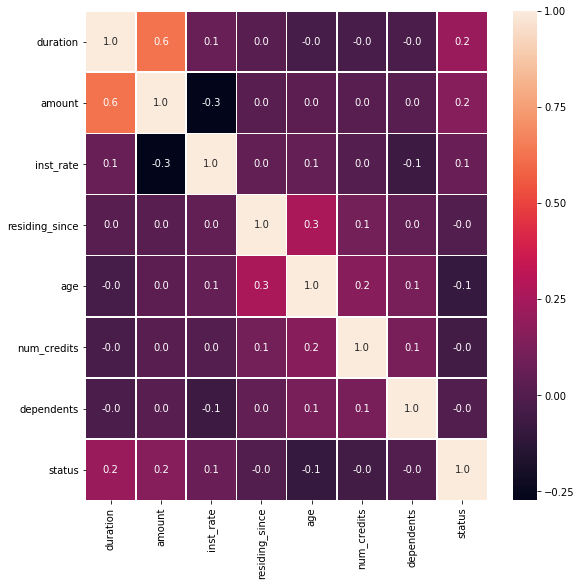

In [58]:
f,ax = plt.subplots(figsize=(9, 9))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [62]:
df['inst_rate'].unique()

array([6, 3, 5, 2])

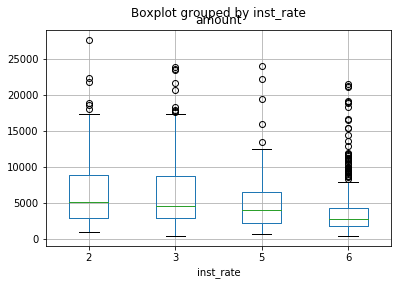

In [60]:
df.boxplot(column='amount',by = 'inst_rate')

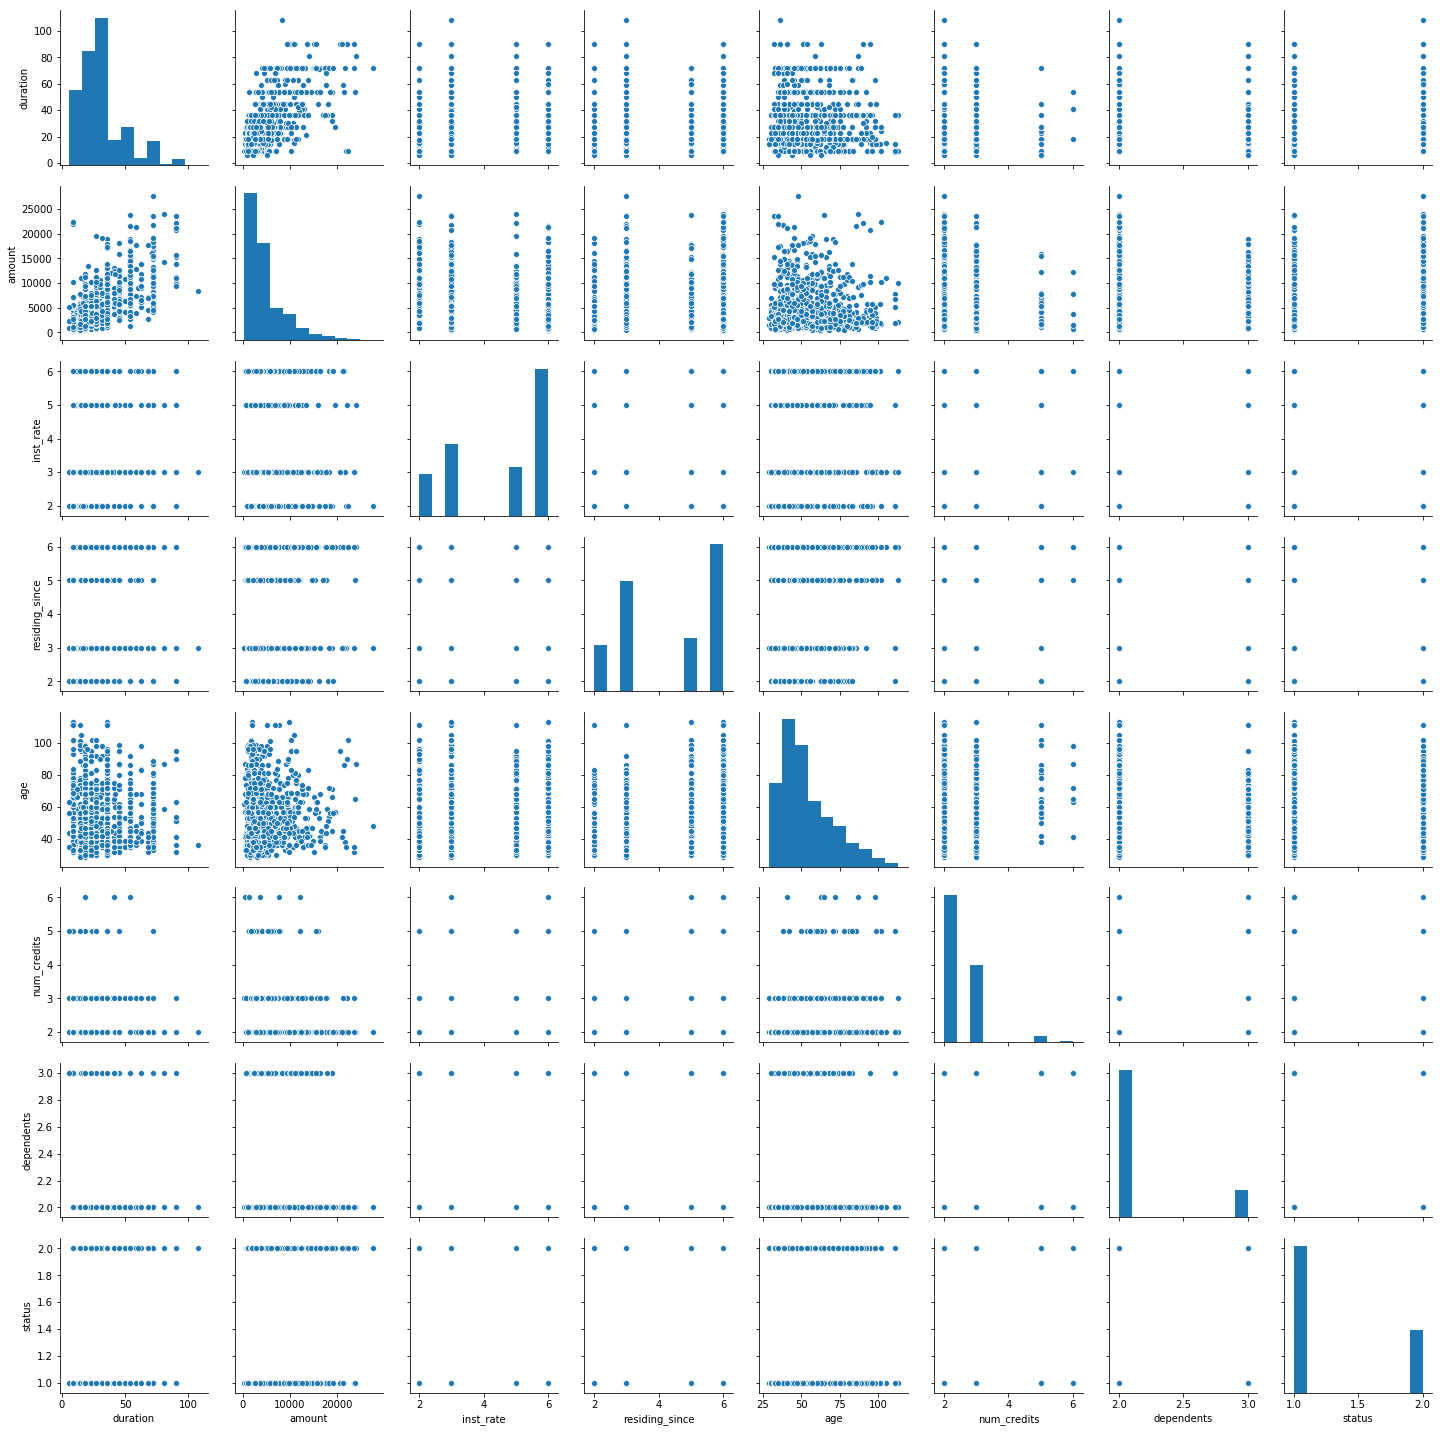

In [63]:
sns.pairplot(df)
plt.show()

# making cateogorical data to numerical using one hot encoding

In [52]:
cf = pd.get_dummies(df)

In [23]:
from sklearn.model_selection import train_test_split

trainX, valX, trainY, valY = train_test_split(cf.drop("status", axis = 1).values, cf['status'].values, test_size=0.4, random_state=0)

In [24]:
cf_train, cf_test = cf.drop("status", axis = 1).values, cf['status'].values

In [25]:
feature_index = feature_selection(trainX, trainY, valX, valY, None, 3, 'AUC', 'SGD')

/usr/lib64/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/lib64/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.

{'alpha': 0.01} features selected: 31
{'alpha': 0.01, 'l1_ratio': 0.1} (600, 61)
{'alpha': 0.01, 'l1_ratio': 0.2} (600, 61)
{'alpha': 0.01, 'l1_ratio': 0.3} (600, 61)
{'alpha': 0.01, 'l1_ratio': 0.4} (600, 61)
{'alpha': 0.01, 'l1_ratio': 0.5} (600, 61)
{'alpha': 0.01, 'l1_ratio': 0.6} (600, 61)
{'alpha': 0.01, 'l1_ratio': 0.7} (600, 61)
{'alpha': 0.01, 'l1_ratio': 0.8} (600, 61)
{'alpha': 0.01, 'l1_ratio': 0.9} (600, 61)
{'alpha': 0.001, 'l1_ratio': 0.1} (600, 61)
{'alpha': 0.001, 'l1_ratio': 0.2} (600, 61)
{'alpha': 0.001, 'l1_ratio': 0.3} (600, 61)
{'alpha': 0.001, 'l1_ratio': 0.4} (600, 61)
{'alpha': 0.001, 'l1_ratio': 0.5} (600, 61)
{'alpha': 0.001, 'l1_ratio': 0.6} (600, 61)
{'alpha': 0.001, 'l1_ratio': 0.7} (600, 61)
{'alpha': 0.001, 'l1_ratio': 0.8} (600, 61)
{'alpha': 0.001, 'l1_ratio': 0.9} (600, 61)
best roc is  0.5740948225026536
Number of features selected: 44


In [26]:
col_dict = {}
count = 0
for item in cf.columns:
    col_dict[item] = count
    count = count+1

In [27]:
my_inverted_dict = {value: key for key, value in col_dict.items()}

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

clf.fit(trainX, trainY)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [30]:
rfc_predict = clf.predict(cf_train)

In [31]:
rfc_cv_score = cross_val_score(clf, cf_train, cf_test, cv=10, scoring='roc_auc')

In [32]:
print("=== Confusion Matrix ===")
print(confusion_matrix(cf_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(cf_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[686  14]
 [ 98 202]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.88      0.98      0.92       700
           2       0.94      0.67      0.78       300

   micro avg       0.89      0.89      0.89      1000
   macro avg       0.91      0.83      0.85      1000
weighted avg       0.89      0.89      0.88      1000



=== All AUC Scores ===
[0.84666667 0.72761905 0.78333333 0.75714286 0.80809524 0.88761905
 0.7047619  0.86428571 0.81428571 0.77190476]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7965714285714285


In [33]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(trainX, trainY)
# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 58 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   55.6s finished


{'n_estimators': 1000, 'max_features': 'auto', 'max_depth': 140}


In [42]:
rfc = RandomForestClassifier(**rfc_random.best_params_)
rfc.fit(trainX, trainY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=140, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [43]:
rfc_predict = rfc.predict(cf_train)

rfc_cv_score = cross_val_score(rfc, cf_train, cf_test, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(cf_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(cf_test, rfc_predict))
print('\n')
print("=== All AUC Scores ===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[679  21]
 [ 71 229]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.91      0.97      0.94       700
           2       0.92      0.76      0.83       300

   micro avg       0.91      0.91      0.91      1000
   macro avg       0.91      0.87      0.88      1000
weighted avg       0.91      0.91      0.91      1000



=== All AUC Scores ===
[0.82333333 0.74619048 0.7947619  0.78833333 0.81761905 0.8702381
 0.75357143 0.84142857 0.81166667 0.77809524]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.8025238095238094


In [45]:
from xgboost import XGBClassifier
model = XGBClassifier()

model.fit(trainX, trainY)

model.feature_importances_.argsort()

xgb_predict = model.predict(cf_train)

xgb_cv_score = cross_val_score(model, cf_train, cf_test, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(cf_test, xgb_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(cf_test, xgb_predict))
print('\n')
print("=== All AUC Scores ===")
print(xgb_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", xgb_cv_score.mean())

=== Confusion Matrix ===
[[665  35]
 [119 181]]


=== Classification Report ===
              precision    recall  f1-score   support

           1       0.85      0.95      0.90       700
           2       0.84      0.60      0.70       300

   micro avg       0.85      0.85      0.85      1000
   macro avg       0.84      0.78      0.80      1000
weighted avg       0.85      0.85      0.84      1000



=== All AUC Scores ===
[0.85285714 0.74952381 0.78952381 0.75904762 0.79142857 0.83619048
 0.70666667 0.85047619 0.78428571 0.79047619]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.791047619047619


In [ ]:
check_sgd = []
for item in feature_index:
#     print (my_inverted_dict[item])
    check_sgd.append(my_inverted_dict[item])
check_clf = []
for item in clf.feature_importances_.argsort():
#     print (my_inverted_dict[item])
    check_clf.append(my_inverted_dict[item])
check_rfc = []
for item in rfc.feature_importances_.argsort():
#     print (my_inverted_dict[item])
    check_rfc.append(my_inverted_dict[item])

In [50]:
check_xgb = []
for item in model.feature_importances_.argsort():
#     print (my_inverted_dict[item])
    check_xgb.append(my_inverted_dict[item])

In [88]:
print(df.columns)

Index([u'checkin_acc', u'duration', u'credit_history', u'purpose', u'amount',
       u'svaing_acc', u'present_emp_since', u'inst_rate', u'personal_status',
       u'other_debtors', u'residing_since', u'property', u'age', u'inst_plans',
       u'housing', u'num_credits', u'job', u'dependents', u'telephone',
       u'foreign_worker', u'status'],
      dtype='object')


In [87]:
print(len(df.columns))

21


# importance of features by random forest

In [84]:
print (check_clf)

['purpose_A43', 'purpose_A46', 'purpose_A41', 'housing_A153', 'foreign_worker_A201', 'purpose_A44', 'telephone_A192', 'svaing_acc_A65', 'present_emp_since_A75', 'inst_plans_A141', 'svaing_acc_A63', 'svaing_acc_A62', 'purpose_A45', 'personal_status_A93', 'other_debtors_A102', 'housing_A152', 'other_debtors_A101', 'personal_status_A94', 'svaing_acc_A61', 'checkin_acc_A12', 'purpose_A410', 'personal_status_A92', 'present_emp_since_A73', 'property_A122', 'checkin_acc_A14', 'job_A171', 'purpose_A48', 'job_A173', 'present_emp_since_A72', 'personal_status_A91', 'property_A124', 'property_A123', 'dependents', 'credit_history_A32', 'inst_plans_A143', 'purpose_A42', 'credit_history_A31', 'present_emp_since_A74', 'job_A174', 'housing_A151', 'telephone_A191', 'checkin_acc_A11', 'credit_history_A30', 'inst_plans_A142', 'svaing_acc_A64', 'property_A121', 'credit_history_A34', 'job_A172', 'purpose_A40', 'purpose_A49', 'num_credits', 'other_debtors_A103', 'present_emp_since_A71', 'credit_history_A33',

# importance of features by SGD

In [85]:
print(check_sgd)

['duration', 'amount', 'inst_rate', 'residing_since', 'age', 'num_credits', 'dependents', 'status', 'checkin_acc_A11', 'checkin_acc_A12', 'checkin_acc_A13', 'checkin_acc_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A42', 'purpose_A48', 'svaing_acc_A61', 'svaing_acc_A62', 'svaing_acc_A63', 'svaing_acc_A64', 'present_emp_since_A71', 'present_emp_since_A72', 'present_emp_since_A73', 'present_emp_since_A74', 'personal_status_A92', 'personal_status_A93', 'personal_status_A94', 'other_debtors_A102', 'other_debtors_A103', 'property_A122', 'property_A123', 'inst_plans_A141', 'inst_plans_A142', 'inst_plans_A143', 'housing_A151', 'job_A172', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201']


# importance of features by xgb

In [86]:
print(check_xgb)

['foreign_worker_A201', 'telephone_A191', 'present_emp_since_A75', 'present_emp_since_A74', 'housing_A153', 'svaing_acc_A65', 'svaing_acc_A63', 'svaing_acc_A62', 'purpose_A46', 'inst_plans_A141', 'purpose_A45', 'purpose_A43', 'purpose_A41', 'purpose_A48', 'purpose_A410', 'job_A171', 'property_A123', 'housing_A152', 'present_emp_since_A72', 'personal_status_A93', 'purpose_A44', 'personal_status_A92', 'property_A121', 'purpose_A42', 'credit_history_A32', 'personal_status_A94', 'housing_A151', 'property_A122', 'inst_plans_A142', 'personal_status_A91', 'other_debtors_A101', 'job_A173', 'svaing_acc_A61', 'checkin_acc_A12', 'num_credits', 'credit_history_A31', 'property_A124', 'present_emp_since_A73', 'other_debtors_A102', 'svaing_acc_A64', 'dependents', 'checkin_acc_A14', 'telephone_A192', 'checkin_acc_A11', 'job_A174', 'inst_rate', 'inst_plans_A143', 'other_debtors_A103', 'status', 'credit_history_A30', 'credit_history_A33', 'credit_history_A34', 'job_A172', 'purpose_A49', 'checkin_acc_A13